In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm, skew

In [2]:
df = pd.read_csv("../data/train.csv")

## Let's start with some basic EDA and data cleaning.

#### What kind of data do I have here? What columns do I have? What do they mean? Which values are ordinal, discrete, continuous?

These column names have spaces. I want to be able to easy refer to them and type them with tab-complete, so I'm going to replace those spaces with `_`.

In [3]:
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
df.columns = cols

Ahhh. Much better.

In [4]:
df.describe()

Id           PID  MS_SubClass  Lot_Frontage       Lot_Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall_Qual  Overall_Cond   Year_Built  Year_Remod/Add  Mas_Vnr_Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

           ...        Wood_Deck_SF  Open_Porch_SF  Enclosed_Porch  \
count      ...         2051.000000    2051.000000     2051.000000   
mean       ...           93.833740      47.556802       22.571916   
std        ...          128.549416      66.747241       59.845110   
min        ...            0.000000       0.000000        0.000000   
25%        ...            0.000000       0.000000        0.000000   
50%        ...            0.000000      27.000000        0.000000   
75%        ...          168.000000      70.000000        0.000000   
max        ...         1424.000000     547.000000      432.000000   

        3Ssn_Porch  Screen_Porch    Pool_Area      Misc_Val      Mo_Sold  \
count  2051.000000   2051.000000  2051.000000   2051.000000  2051.000000   
mean      2.591419     16.511458     2.397855     51.574354     6.219893   
std      25.229615     57.374204    37.782570    573.393985     2.744736   
min       0.000000      0.000000     0.000000      0.000000     1.000000   
25%       0.000000      0.000000     0.000000      0.000000     4.000000   
50%       0.000000      0.000000     0.000000      0.000000     6.000000   
75%       0.000000      0.000000     0.000000      0.000000     8.000000   
max     508.000000    490.000000   800.000000  17000.000000    12.000000   

           Yr_Sold      SalePrice  
count  2051.000000    2051.000000  
mean   2007.775719  181469.701609  
std       1.312014   79258.659352  
min    2006.000000   12789.000000  
25%    2007.000000  129825.000000  
50%    2008.000000  162500.000000  
75%    2009.000000  214000.000000  
max    2010.000000  611657.000000  

[8 rows x 39 columns]

Okay, now I can see some basic stats for my numeric columns. Good to know.

### Missing Values!

Okay, so we do have some missing values. Not all of those above columns have 2051 values. I'll go through and see what I need to fix by running `df.isnull().sum()`

There are a lot of columns that are filled with `nan`'s when in reality, they simply represent "None" - the absence of a feature. I'll write a function that takes in these categorical columns, and replaces the `nan`'s with "None" so that they mean something and can be dummied in the future.

## Bold one liners

In [5]:
def replace_na_none(columns):
    for x in columns:
        df[x].fillna("None", inplace=True)

In [6]:
replace_na_none(["Alley","Mas_Vnr_Type","Bsmt_Cond","Bsmt_Qual","Bsmt_Exposure","BsmtFin_Type_1","BsmtFin_Type_2",
                 "Fireplace_Qu","Garage_Type","Garage_Yr_Blt","Garage_Finish",
                 "Garage_Qual","Garage_Cond","Pool_QC","Fence","Misc_Feature"])

Great. That's done. Now I need to handle the `0`'s and `nan`'s in all of our numeric columns. But to do that, I want to quickly see which columns still have null values, and how many.

In [7]:
def are_null():
    for x in df.columns:
        a = df[x].isnull().sum()
        if a:
            print(x, df[x].isnull().sum())

In [8]:
are_null()

Lot_Frontage 330
Mas_Vnr_Area 22
BsmtFin_SF_1 1
BsmtFin_SF_2 1
Bsmt_Unf_SF 1
Total_Bsmt_SF 1
Bsmt_Full_Bath 2
Bsmt_Half_Bath 2
Garage_Cars 1
Garage_Area 1


**I have a feeling that those columns that have 1-2 nulls in similar columns might have some overlap.**

In [9]:
df.loc[np.isnan(df['Bsmt_Full_Bath']),
       ['MS_Zoning','Lot_Frontage','Mas_Vnr_Area','BsmtFin_SF_1','BsmtFin_SF_2',
        'Bsmt_Unf_SF','Total_Bsmt_SF','Bsmt_Full_Bath','Bsmt_Half_Bath','Garage_Cars','Garage_Area']]

MS_Zoning  Lot_Frontage  Mas_Vnr_Area  BsmtFin_SF_1  BsmtFin_SF_2  \
616         RL         123.0           0.0           0.0           0.0   
1327        RM          99.0           0.0           NaN           NaN   

      Bsmt_Unf_SF  Total_Bsmt_SF  Bsmt_Full_Bath  Bsmt_Half_Bath  Garage_Cars  \
616           0.0            0.0             NaN             NaN          2.0   
1327          NaN            NaN             NaN             NaN          1.0   

      Garage_Area  
616         624.0  
1327        280.0

**Look at that! One row has nearly all null values. I'm going to drop it since replacing all those isn't worth it, and it won't really affect my future model. The other row has 2 nulls, and a lot of zeros. I'll drop that too.**

In [10]:
df.dropna(subset=['Bsmt_Full_Bath'],inplace=True)

**What's left? After checking `are_null()` there's one column that has `Garage_Cars` and `Garage_Area` empty. Let me investigate.**

In [11]:
df[np.isnan(df['Garage_Area'])][['MS_Zoning','Garage_Area','Garage_Cars','SalePrice']]

MS_Zoning  Garage_Area  Garage_Cars  SalePrice
1712        RM          NaN          NaN     150909

In [12]:
df[(df['Garage_Cars'] == 0) & (df['Garage_Area'] == 0)][['MS_Zoning','Garage_Area','Garage_Cars','SalePrice']].head()

MS_Zoning  Garage_Area  Garage_Cars  SalePrice
28    C (all)          0.0          0.0     119600
53         RM          0.0          0.0      76000
65         RL          0.0          0.0     147000
79         RM          0.0          0.0     129850
101        RL          0.0          0.0      86000

 **There are many rows with both `Garage_Cars` and `Garage_Area` as `0.0`. Since I have a row that has both of them as null, I'll set them to `0` to follow those other rows.**

In [13]:
df['Garage_Cars'].fillna(0.0,inplace=True)
df['Garage_Area'].fillna(0.0,inplace=True)

The only thing left are checking `are_null()` are `Lot_Frontage` with 330 nulls, and `Mas_Vnr_Area` with 22.

That leaves two columns with nulls, but they make up nearly 20% of our data. This is where it gets tricky and confusing. Because I can't simply make all these values `0`'s. That would hurt the end model. And I can't drop these rows because they probably contain valuable data. 

However! I know that `Lot_Frontage` and `Mas_Vnr_Area` are values that aren't specific for every house. Not every house has land on the front connecting to the street, and not every house has a masonry veneer. Let me just check that - if these are null - than their corresponding value is also set to NA. If so, I can set them all to `0.0`.

In [14]:
df[(df['Mas_Vnr_Area'] == 0)][['Mas_Vnr_Area','Mas_Vnr_Type','SalePrice']].head()

Mas_Vnr_Area Mas_Vnr_Type  SalePrice
2           0.0         None     109000
3           0.0         None     174000
4           0.0         None     138500
5           0.0         None     190000
8           0.0         None     112500

In [15]:
df['Mas_Vnr_Area'].fillna(0.0,inplace=True)
df['Lot_Frontage'].fillna(0.0,inplace=True)

**Great! All of our 0's and null's have been dealt with! In summary, these are the values that we 0-ed:**

`df['Garage_Cars'].fillna(0.0,inplace=True)
df['Garage_Area'].fillna(0.0,inplace=True)
df['Mas_Vnr_Area'].fillna(0.0,inplace=True)
df['Lot_Frontage'].fillna(0.0,inplace=True)`

## EDA TIME!

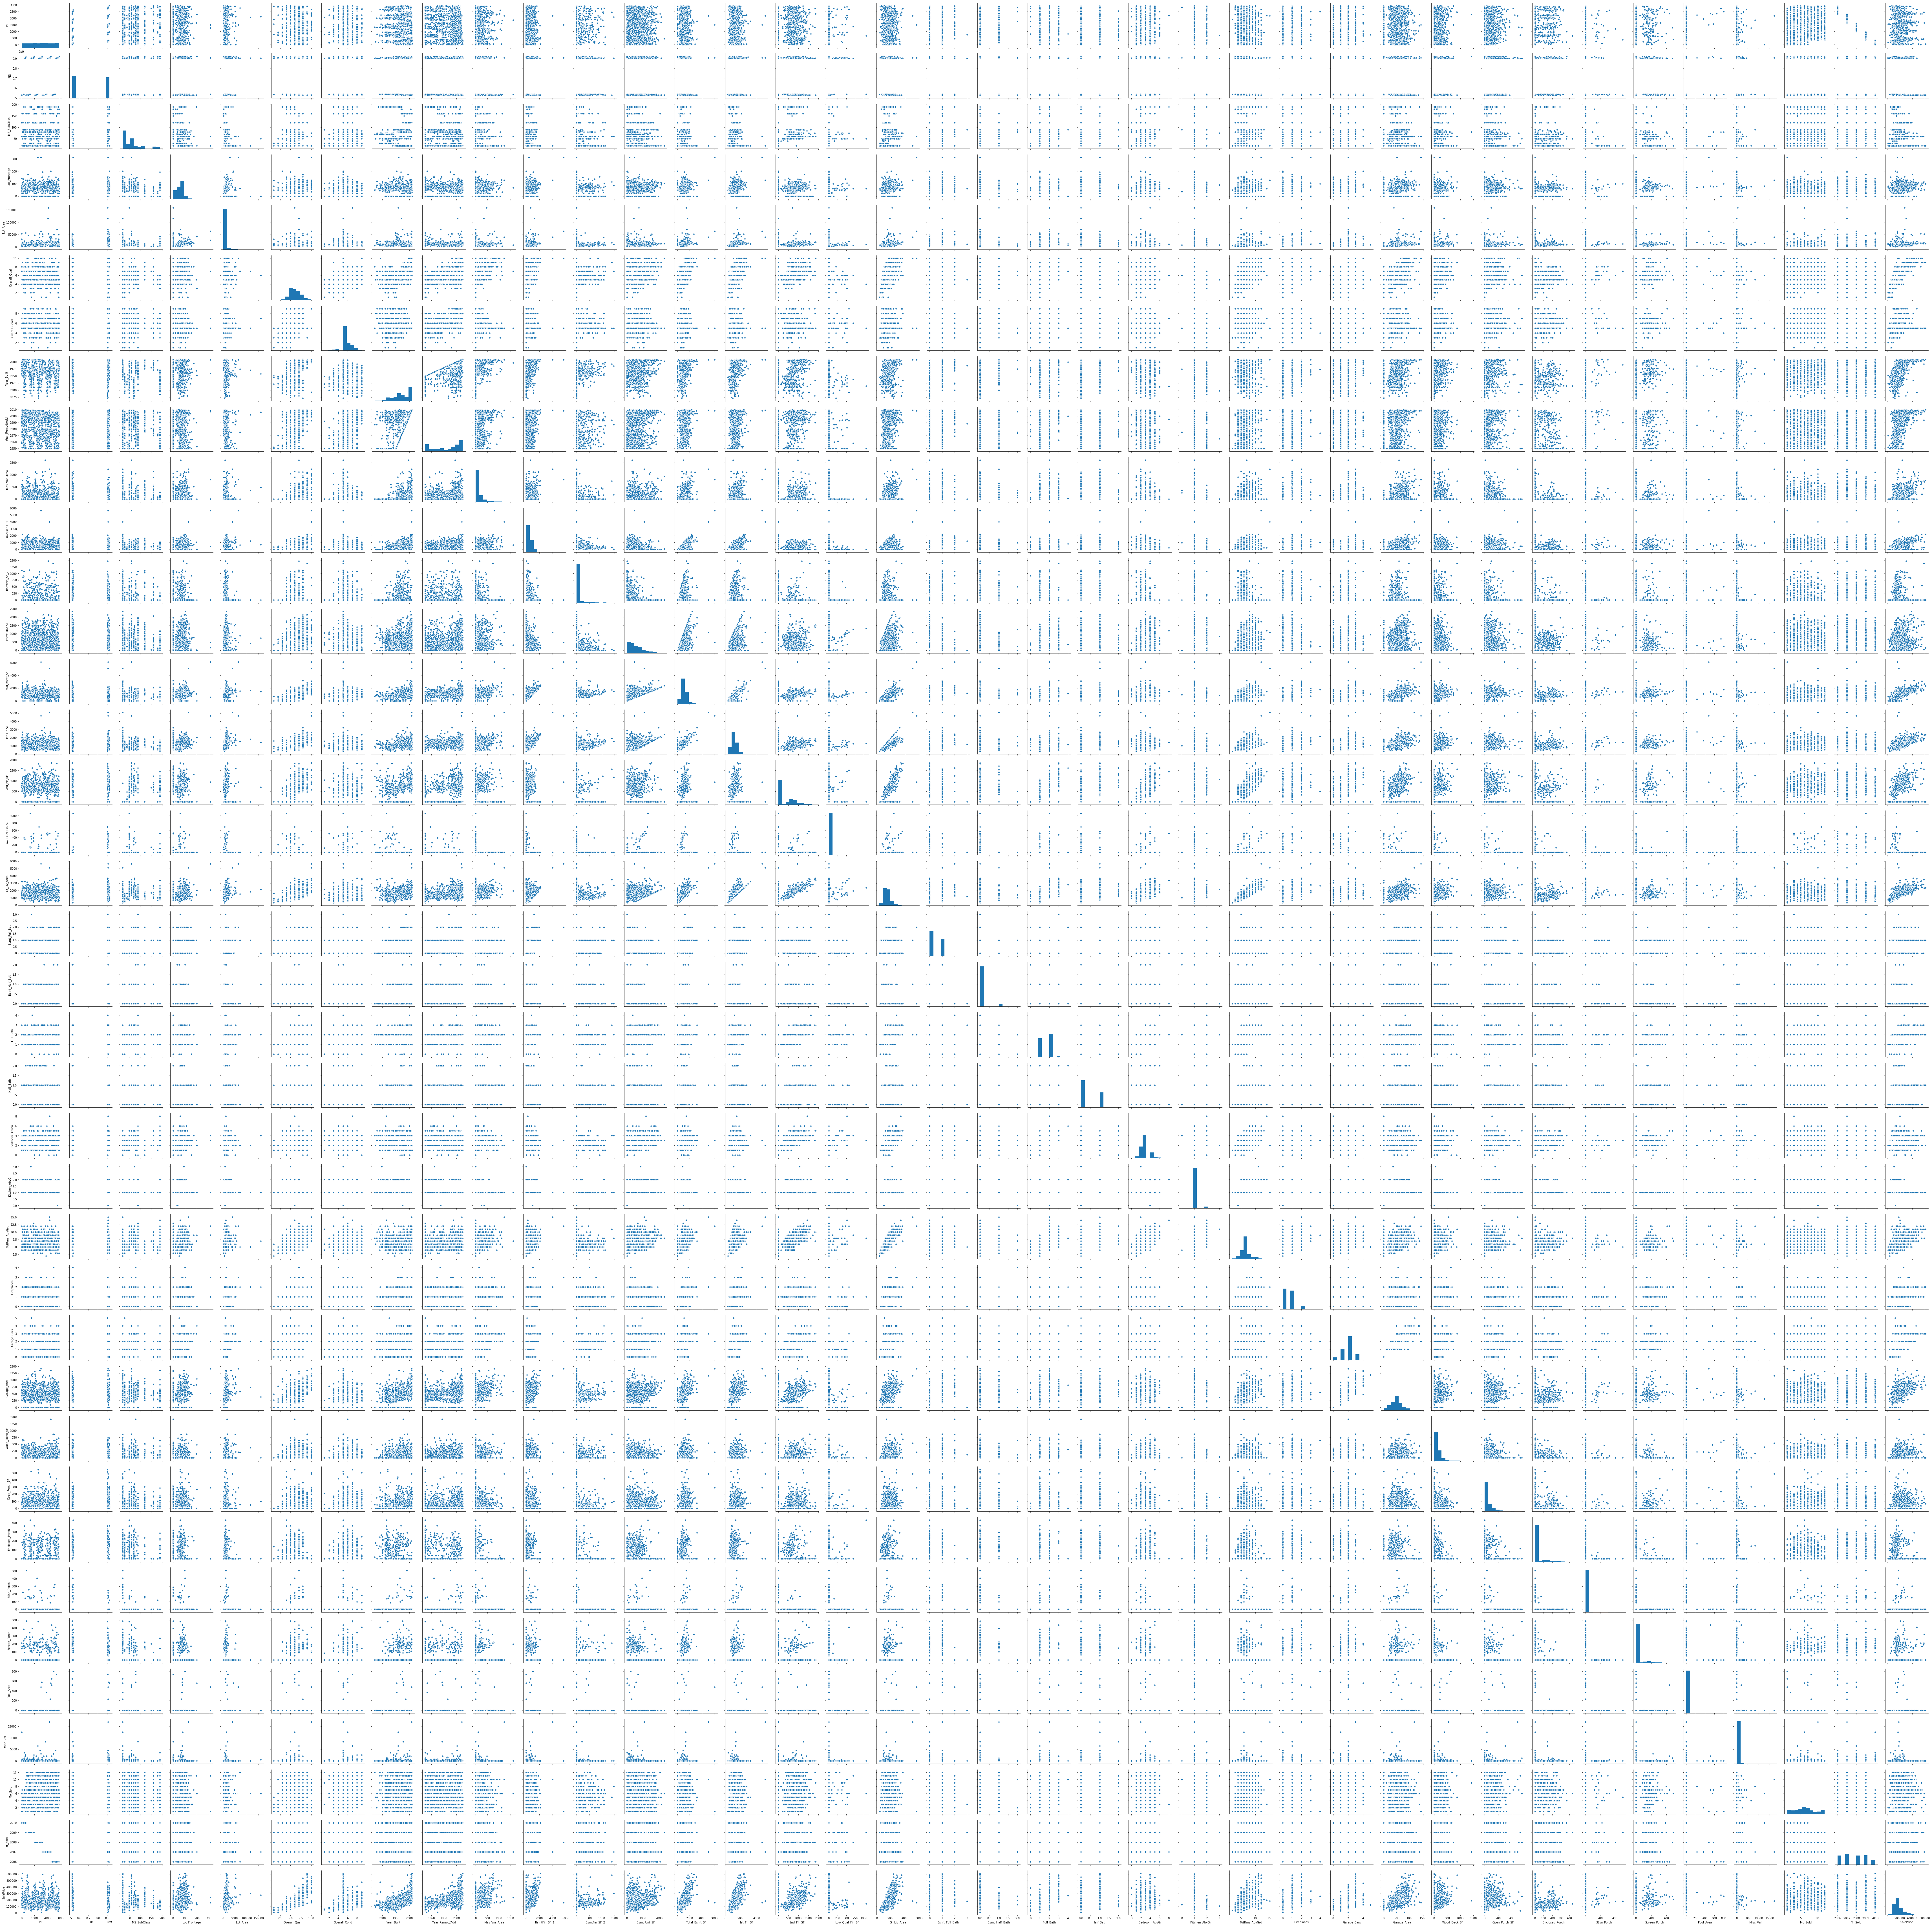

In [16]:
sns.pairplot(df)

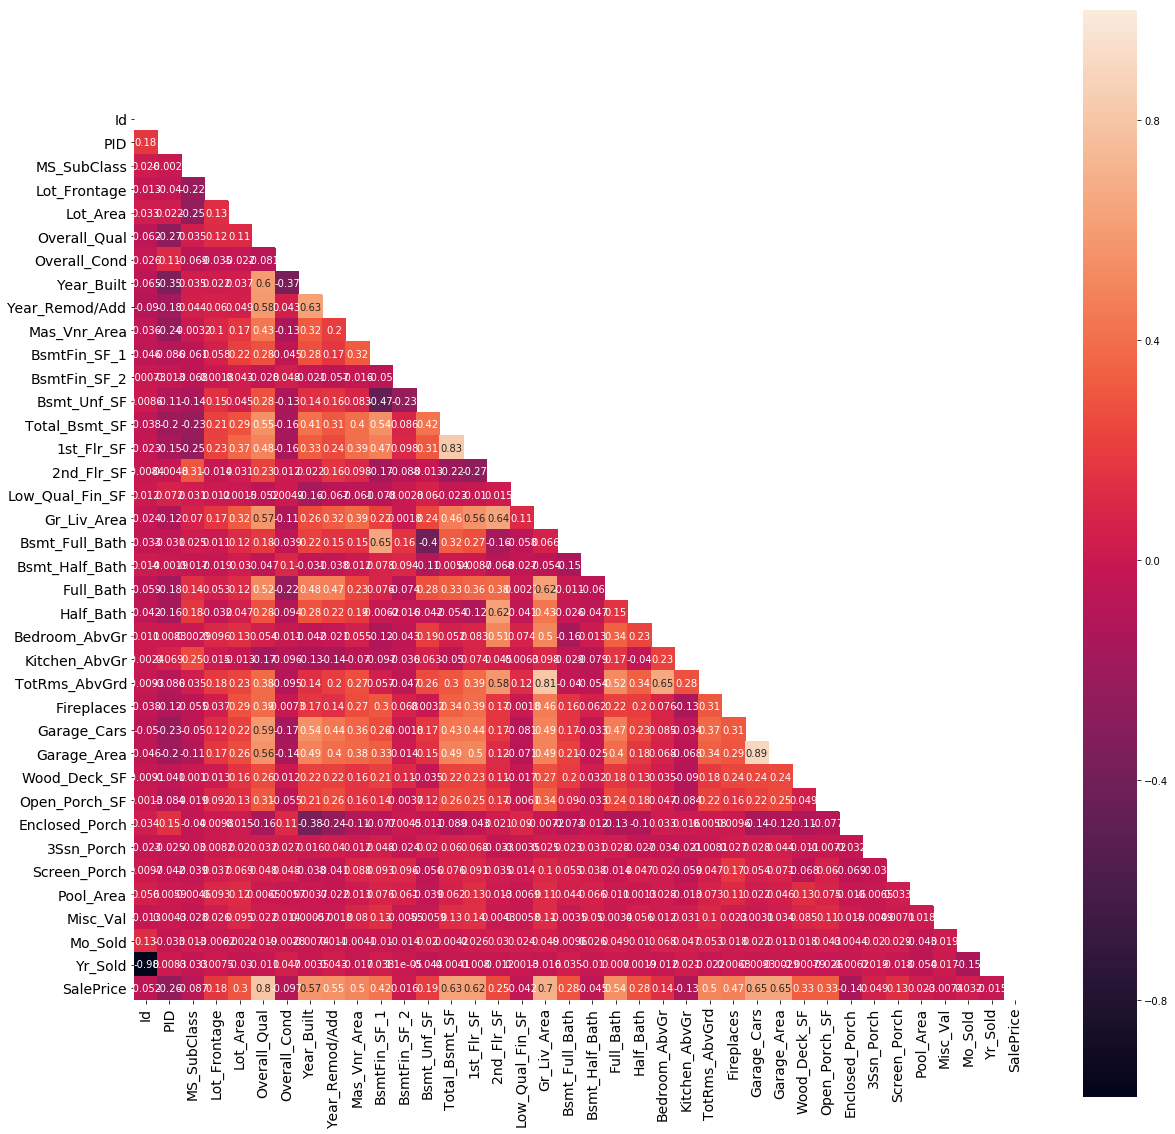

In [17]:
g,ax = plt.subplots(figsize=(20,20))

mask = np.zeros_like(df.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot=True,square=True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 14)

plt.show()

### Dropping overlapping features

I want to really focus on features that overlap and remove any overlapping columns. Since I'm going to be doing LinearRegression, I have to ensure that my assumptions are met; one of them being variable overlap.

There's a lot of columns dealing with Basement, Square-footage, and Rooms.

I'll start with Basements: how many houses have both types of basements, and if their quality differs.
Using variations of this `df[df['BsmtFin_Type_1'] != df['BsmtFin_Type_2']][['BsmtFin_Type_1','BsmtFin_Type_2']]` I found:
- 655 with the same Fin_Type (most of which are 'None' or 'Unf')
- 1372 with different Fin_Type
- 0 without Bsmt_1 and with Bsmt_2
- 1 with Bsmt_1 and without Bsmt_2

What does this tell me? I can simply use `Total_Bsmt_SF` and remove the others. I don't need to worry about types/quality just yet, since this can still have an effect and don't overlap. I can do the same for `Gr_Liv_Area` and `TotRms_AbvGrd`.

In [18]:
df.drop(['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF'],axis=1,inplace=True)
df.drop(['1st_Flr_SF', '2nd_Flr_SF', 'Low_Qual_Fin_SF'],axis=1,inplace=True)
df.drop(['Bedroom_AbvGr'],axis=1,inplace=True)

**Now I want to create and look at some scatter plots that will help me find columns that have the highest correlation on `SalePrice`.**

In [19]:
numeric = list(df.select_dtypes(exclude='object').columns)[2:30]
strings = df.select_dtypes(exclude=['int64','float64']).columns

In [20]:
def make_scatter_plots(cols):
    f,axes = plt.subplots(7,4,figsize=(30,30))
    for ax,var in zip(axes.flatten(),cols):
        ax.set_title(var + " vs. Price", fontsize=13)
        ax.set_xlabel("SalePrice", fontsize=9)
        ax.set_ylabel(var, fontsize=17)
        ax.scatter(df["SalePrice"],df[var])

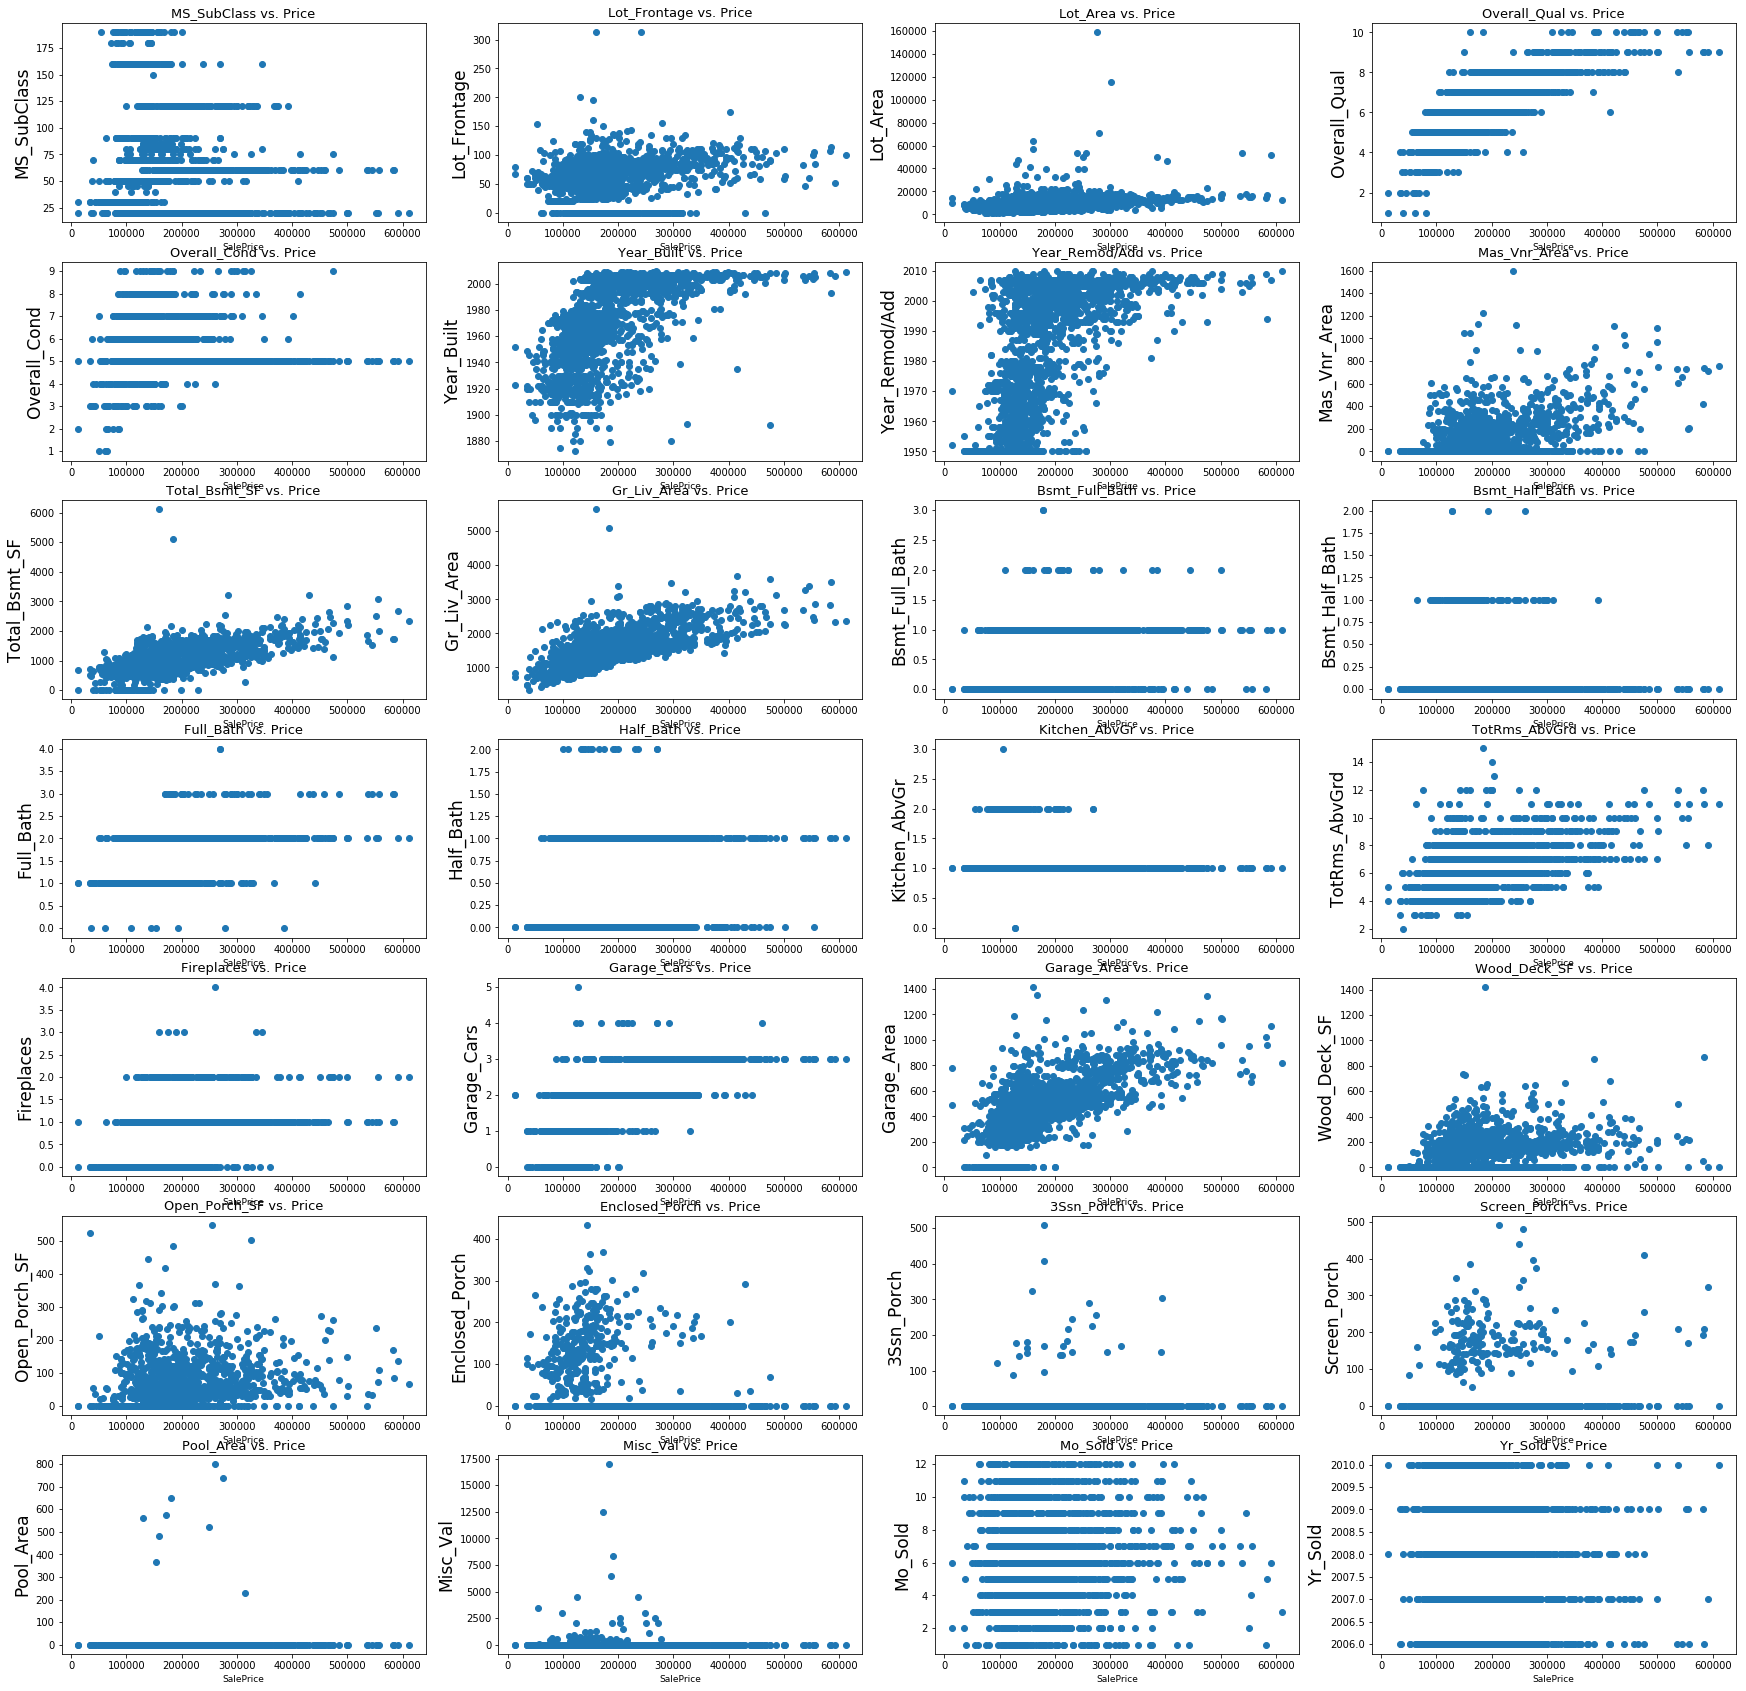

In [21]:
make_scatter_plots(numeric)

#### Outliers!

I can get a good feel for possible outliers looking at these scatter plots. If the entire chart is consistent with one or two values at the very edge, I'll go ahead and remove those.

In [22]:
df.drop(df[df['Lot_Frontage'] > 250].index,inplace=True)
df.drop(df[df['Lot_Area'] > 100000].index,inplace=True)
df.drop(df[df['Bsmt_Full_Bath'] >= 3].index,inplace=True)
df.drop(df[df['Full_Bath'] >= 4].index,inplace=True)
df.drop(df[(df['Kitchen_AbvGr'] >= 3) | (df['Kitchen_AbvGr'] <= 0)].index,inplace=True)
df.drop(df[(df['TotRms_AbvGrd'] >= 13)].index,inplace=True)
df.drop(df[(df['Fireplaces'] >= 4)].index,inplace=True)
df.drop(df[(df['Garage_Cars'] >= 5)].index,inplace=True)
df.drop(df[(df['Wood_Deck_SF'] >= 1250)].index,inplace=True)
df.drop(df[(df['Misc_Val'] >= 10000)].index,inplace=True)
df.drop(df[df['Year_Remod/Add'] < df['Year_Built']].index,inplace=True)
df.drop(df[(df['SalePrice'] < 30000)].index,inplace=True)

### Possible Features & Feature Engineering!

In [23]:
def over_half_corr(cols):
    high_corr_dict = pd.DataFrame()
    for var in cols:
        corr = np.corrcoef(df['SalePrice'],df[var])[0,1]
        if np.absolute(corr) > .47:
            high_corr_dict.loc[var,"Correlation"] = corr
    return high_corr_dict

In [24]:
over_half_corr(numeric)

Correlation
Overall_Qual       0.804010
Year_Built         0.573915
Year_Remod/Add     0.549359
Mas_Vnr_Area       0.513430
Total_Bsmt_SF      0.667301
Gr_Liv_Area        0.723442
Full_Bath          0.539901
TotRms_AbvGrd      0.514282
Fireplaces         0.472363
Garage_Cars        0.658348
Garage_Area        0.663790

These will be the numerical features that I expect will have the largest coefficients when building out a sophisticated model.

However, there it's possible that there will be overlap between these features, and there are many categorical features that can also have a huge effect. That's an aspect I will need to look at an decide on which of these I want to include.

I could also look into creating interaction features. I'll keep that as a possible option when I start building out models. 

### Deskew the prices!
As always, it's good to also deskew the target variable. I'll go ahead and do that now so I have deskewed values for my y_train/y_test values before I start modeling.

In [25]:
df["SalePrice_deskewed"] = np.log1p(df["SalePrice"])

**Finally! Time to save all my cleaned and ready-to-work-with data!**

In [26]:
df.to_csv('../data/cleaned.csv')